# GIGO in Practice: Data Quality Pipelines for Reliable Data Science

**Author:** Amantha Bhaskarabhatla

**Course:** INFO 7390 – Advanced Data Science and Architecture  


## 1. Why GIGO Matters

In data science, you face a hard truth:

GIGO – Garbage In, Garbage Out

If your data's junk, then whatever you get out - like reports or charts - is gonna be junk too.

Even strong models - like XGBoost or deep nets - might fail if fed poor data, since garbage in means garbage out; worse yet, LLMs amplify those flaws fast

- Bad choices in running the company
- Models that favor one side or aren't fair
- Misleading dashboards
- Losing faith in AI

In this notebook, we’re going to -

1. Get what GIGO means along with why good data matters
2. Create a practical data-checking system using Python
3. Check what happens when tidying up shifts the way you see your work


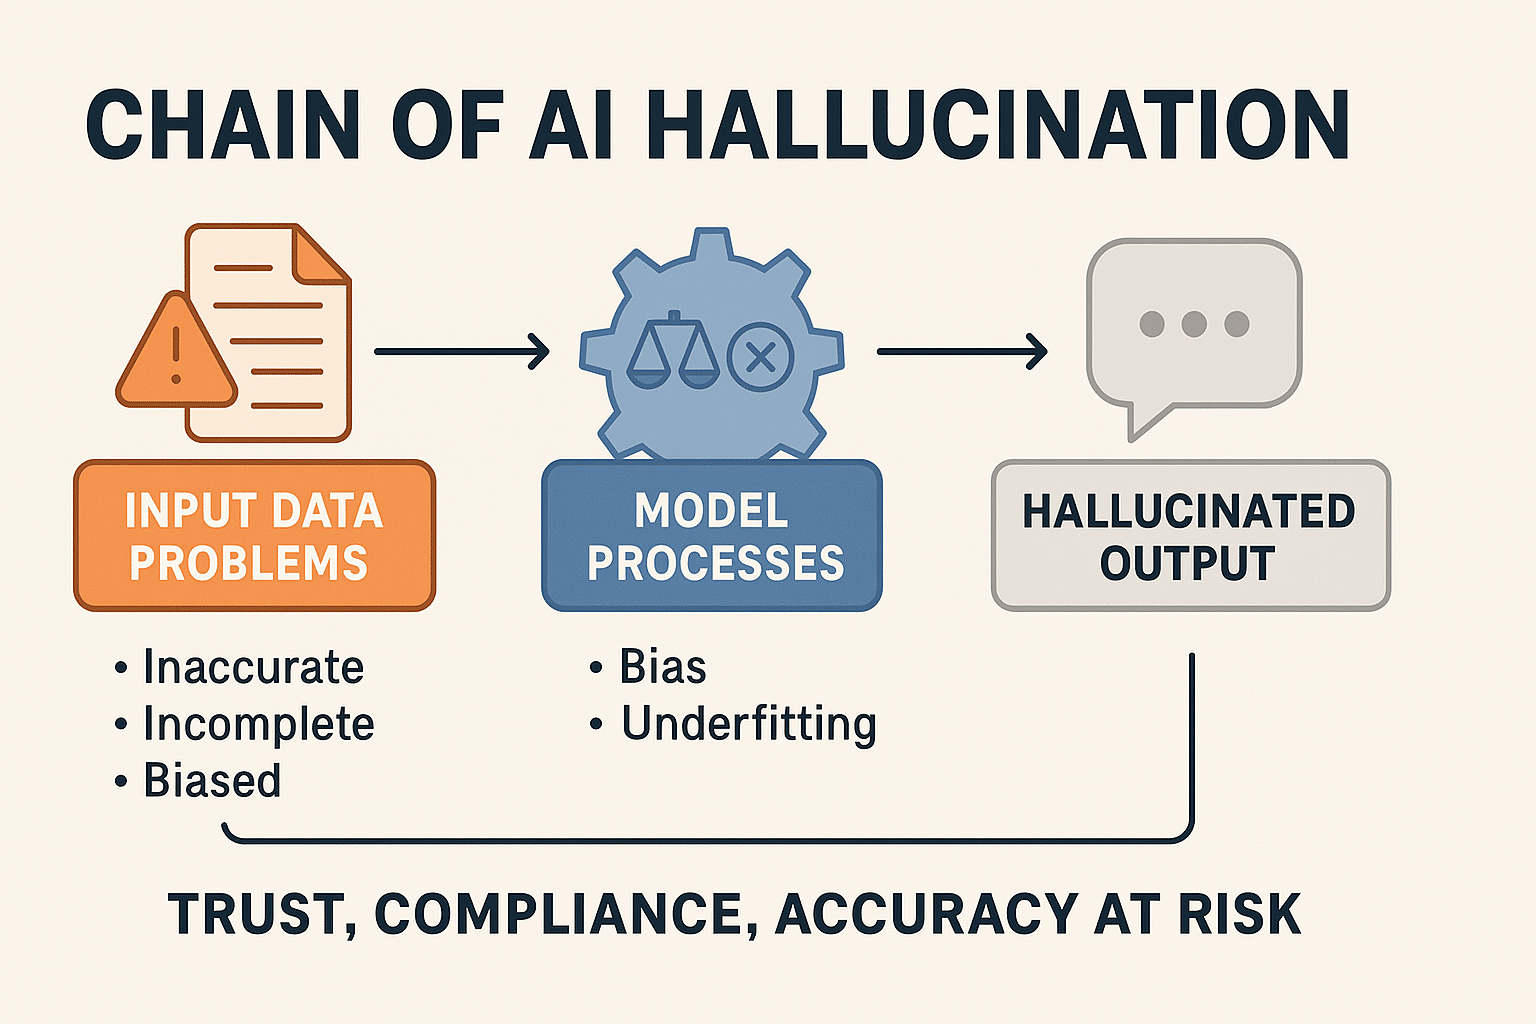

##2. Theoretical Foundations: GIGO & Data Quality

**2.1 What is GIGO?**

GIGO (Garbage In, Garbage Out) is a principle from early computing:

If things are off, missing stuff, leaning one way, or don't match up,
The result’ll miss the mark - even if the math looks slick

GIGO matters a lot in data science workflows - especially since we usually pay attention to:
- "Which model should I use?"
- "What hyperparameters are best?"

and ignore:

- "Is my data even valid?"
- "Do the values make sense?"
- "What assumptions am I making about the data?"



**2.2 Data Quality Dimensions**

To turn a saying into action, you’ll want clear traits for good data. While ideas sound nice, real results depend on measurable parts.
Several options exist - here’s an easy pick for this guide:

1. Completeness

Got some values missing?

- Like, age shows up as NaN in lots of spots.

2. Validity

Check if values fit within permitted limits or correct forms.

- Like age below 0 or above 120, also transactions with minus values.

3. Consistency

- Do the numbers match up between areas or follow company guidelines?

- Like: Area tags missing from the okay pile.

4. Uniqueness

- Any accidental copies hanging around?

Same line shows up more than once.

5. Reasonableness / Outliers

Could certain numbers seem way off? Might a few figures look too wild to be true?

A transaction worth 1 million shows up in a tiny store's data set.

We'll put together a little system which looks at those aspects, then makes them better.



**2.3 Data Quality in a DS Pipeline**

Conceptual data flow diagram:

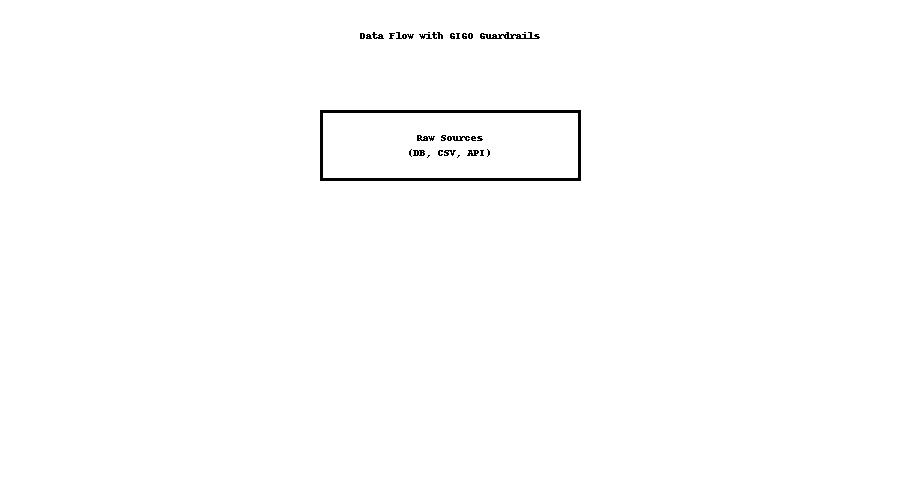


### What we will build

We’ll simulate a **transaction dataset** with:

- `customer_id`
- `age`
- `country`
- `product_category`
- `transaction_amount`

Then we will:

1. **Inject garbage** into it (missing values, invalid ranges, etc.).  
2. Implement a **data quality report** (diagnose).  
3. Implement a **cleaning pipeline** (treat).  
4. Compare **average transaction amount per country** before vs after cleaning.

## 4. Environment Setup

Run the following cell to import Python libraries.


In [1]:

!pip install pandas numpy matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 20)


## 5. Step 1 – Create a Base (Reasonably Clean) Dataset

We simulate a simple dataset representing **customer transactions**:

- Each row = one transaction  
- `customer_id` = integer ID  
- `age` = customer age  
- `country` = country code from a small set  
- `product_category` = type of product  
- `transaction_amount` = purchase amount  

We start with a **reasonable** dataset, then we will **corrupt it on purpose** to demonstrate GIGO.


In [21]:
np.random.seed(42)

n_rows = 500

customer_ids = np.random.randint(1000, 2000, size=n_rows)
ages = np.random.randint(18, 80, size=n_rows)
countries = np.random.choice(
    ["US", "UK", "IN", "DE", "CA"],
    size=n_rows,
    p=[0.3, 0.2, 0.2, 0.15, 0.15]
)
product_categories = np.random.choice(
    ["Electronics", "Clothing", "Grocery", "Beauty"],
    size=n_rows
)
transaction_amounts = np.round(np.random.exponential(scale=50, size=n_rows) + 10, 2)

base_df = pd.DataFrame({
    "customer_id": customer_ids,
    "age": ages,
    "country": countries,
    "product_category": product_categories,
    "transaction_amount": transaction_amounts
})

base_df.head()


customer_id  age country product_category  transaction_amount
0         1102   20      UK          Grocery               34.92
1         1435   57      DE         Clothing               42.69
2         1860   63      CA      Electronics               55.82
3         1270   41      US         Clothing               27.24
4         1106   67      IN         Clothing               69.37

In [22]:
print("Base dataset info:")
print(base_df.info())

print("\nSummary stats for base dataset:")
display(base_df.describe())

print("\nSample rows:")
display(base_df.sample(5, random_state=0))


Base dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         500 non-null    int64  
 1   age                 500 non-null    int64  
 2   country             500 non-null    object 
 3   product_category    500 non-null    object 
 4   transaction_amount  500 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 19.7+ KB
None

Summary stats for base dataset:


customer_id         age  transaction_amount
count   500.000000  500.000000          500.000000
mean   1497.062000   49.820000           60.292720
std     288.267074   17.998764           52.672746
min    1001.000000   18.000000           10.250000
25%    1240.750000   34.000000           23.437500
50%    1494.000000   50.000000           44.515000
75%    1744.750000   66.000000           75.110000
max    1996.000000   79.000000          382.090000


Sample rows:


customer_id  age country product_category  transaction_amount
90          1001   33      US          Grocery              125.48
254         1224   52      US          Grocery               13.11
283         1112   39      CA      Electronics               60.14
445         1282   29      IN           Beauty               13.17
461         1191   75      US           Beauty              295.64

## 6. Step 2 – Inject GIGO: Make the Data Messy

To demonstrate GIGO, we **deliberately inject problems** into the data:

- **Completeness issues:**
  - Missing ages
  - Missing countries

- **Validity issues:**
  - Negative ages
  - Age > 120
  - Negative transaction amounts

- **Reasonableness / outliers:**
  - Extremely large transaction amounts

- **Consistency issues:**
  - Invalid country codes
  - Invalid product categories (e.g., `UnknownCategory`)

- **Uniqueness issues:**
  - Duplicated rows

This simulates messy data from real-world pipelines.


In [4]:
df = base_df.copy()

# 1. Missing ages
missing_age_idx = np.random.choice(df.index, size=20, replace=False)
df.loc[missing_age_idx, "age"] = np.nan

# 2. Impossible ages
df.loc[np.random.choice(df.index, size=5, replace=False), "age"] = -5   # negative
df.loc[np.random.choice(df.index, size=5, replace=False), "age"] = 150  # too large

# 3. Missing countries
missing_country_idx = np.random.choice(df.index, size=15, replace=False)
df.loc[missing_country_idx, "country"] = np.nan

# 4. Invalid product categories
df.loc[np.random.choice(df.index, size=10, replace=False), "product_category"] = "UnknownCategory"

# 5. Negative transaction amounts
df.loc[np.random.choice(df.index, size=8, replace=False), "transaction_amount"] *= -1

# 6. Extreme outliers (multiply some by 20)
df.loc[np.random.choice(df.index, size=5, replace=False), "transaction_amount"] = \
    df["transaction_amount"].max() * 20

# 7. Duplicate some rows
duplicates = df.sample(10, random_state=1)
df = pd.concat([df, duplicates], ignore_index=True)

df.head(10)


customer_id   age country product_category  transaction_amount
0         1102   NaN      UK          Grocery               34.92
1         1435  57.0      DE         Clothing               42.69
2         1860  63.0      CA      Electronics               55.82
3         1270  41.0      US         Clothing               27.24
4         1106  67.0      IN         Clothing               69.37
5         1071  49.0      UK          Grocery              108.35
6         1700  64.0      CA         Clothing               85.67
7         1020  39.0      DE          Grocery               12.02
8         1614  40.0      DE      Electronics               42.75
9         1121  19.0      UK          Grocery               15.54

In [5]:
import os

os.makedirs("data", exist_ok=True)
df.to_csv("data/transactions_dirty.csv", index=False)
print("Saved dirty dataset to data/transactions_dirty.csv")


Saved dirty dataset to data/transactions_dirty.csv


In [23]:
from google.colab import files
files.download("data/transactions_dirty.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Saving the Dirty Example Dataset

So far, `df` exists only inside this notebook as our **corrupted (dirty)** transaction data.

To make this usable as an **example dataset** for learners and scripts (and to satisfy the *“Example scenarios/datasets”* requirement), we save it to a CSV file:

- `os.makedirs("data", exist_ok=True)`  
  → Creates a folder called `data` in the project if it doesn’t already exist.

- `df.to_csv("data/transactions_dirty.csv", index=False)`  
  → Saves the current **dirty transaction data** as  
  `data/transactions_dirty.csv`, which serves as our **example dataset** for the GIGO tutorial.

Later, we (or learners) can load this example dataset with:

```python
df = pd.read_csv("data/transactions_dirty.csv")
```
instead of regenerating the corrupted data from scratch.

## 7. Step 3 – First Diagnostics: How Bad Is the Data?

Now we pretend this is **real raw data** arriving from upstream systems.

We will:

- Check table shape and types  
- Count missing values  
- Count duplicates  
- Inspect basic stats to see if anything looks suspicious

This is the **first GIGO check**: before modeling, understand how “dirty” the data is.
  

In [6]:
print("Current shape:", df.shape)
print("\nInfo:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())

print("\nNumber of duplicated rows:", df.duplicated().sum())


Current shape: (510, 5)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         510 non-null    int64  
 1   age                 490 non-null    float64
 2   country             495 non-null    object 
 3   product_category    510 non-null    object 
 4   transaction_amount  510 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 20.1+ KB
None

Missing values per column:
customer_id            0
age                   20
country               15
product_category       0
transaction_amount     0
dtype: int64

Number of duplicated rows: 10


In [7]:
print("Age stats:")
display(df["age"].describe())

print("\nTransaction amount stats:")
display(df["transaction_amount"].describe())

print("\nUnique countries:", df["country"].unique())
print("Unique product categories:", df["product_category"].unique())


Age stats:


count    490.000000
mean      50.410204
std       21.194713
min       -5.000000
25%       34.000000
50%       50.000000
75%       66.000000
max      150.000000
Name: age, dtype: float64


Transaction amount stats:


count     510.000000
mean      132.639941
std       750.000652
min      -185.180000
25%        22.490000
50%        43.720000
75%        75.717500
max      7641.800000
Name: transaction_amount, dtype: float64


Unique countries: ['UK' 'DE' 'CA' 'US' 'IN' nan]
Unique product categories: ['Grocery' 'Clothing' 'Electronics' 'Beauty' 'UnknownCategory']


## Data Contract & Validation Plan

To turn GIGO into something concrete, we define what **valid data** means:

- `age`: between 18 and 100  
- `country`: one of {US, UK, IN, DE, CA}  
- `product_category`: one of {Electronics, Clothing, Grocery, Beauty}  
- `transaction_amount`: > 0 and ≤ 1000  

We will:

1. Build a **data quality report** (missing + invalid % per column)  
2. Build a **cleaning pipeline**  
3. Compare a simple business metric **before vs after cleaning**  
   → average transaction amount per country


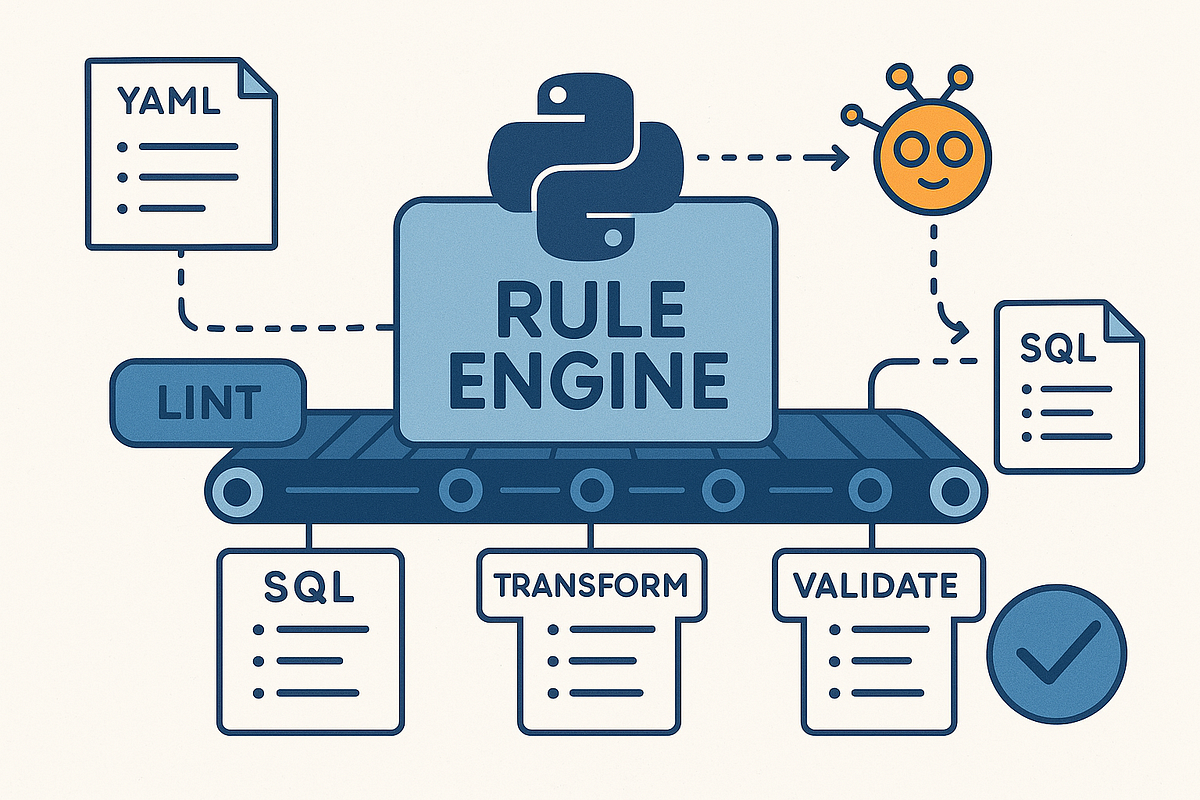

In [8]:
# Validation rules (simple data contract)
allowed_countries = ["US", "UK", "IN", "DE", "CA"]
allowed_categories = ["Electronics", "Clothing", "Grocery", "Beauty"]

validation_rules = {
    "age": {"min": 18, "max": 100},
    "transaction_amount": {"min": 0, "max": 1000},
    "country": {"allowed": allowed_countries},
    "product_category": {"allowed": allowed_categories},
}

def data_quality_report(df: pd.DataFrame, rules: dict) -> pd.DataFrame:
    """
    Simple data quality report:
    - missing_count / missing_pct
    - invalid_count / invalid_pct
    for key columns.
    """
    total_rows = len(df)
    records = []

    # Age
    if "age" in df.columns:
        col = "age"
        missing = df[col].isna().sum()
        invalid = df[col].notna() & (
            (df[col] < rules["age"]["min"]) | (df[col] > rules["age"]["max"])
        )
        records.append({
            "column": col,
            "missing_pct": missing / total_rows * 100,
            "invalid_pct": invalid.sum() / total_rows * 100,
        })

    # Country
    if "country" in df.columns:
        col = "country"
        missing = df[col].isna().sum()
        invalid = df[col].notna() & (~df[col].isin(rules["country"]["allowed"]))
        records.append({
            "column": col,
            "missing_pct": missing / total_rows * 100,
            "invalid_pct": invalid.sum() / total_rows * 100,
        })

    # Product category
    if "product_category" in df.columns:
        col = "product_category"
        missing = df[col].isna().sum()
        invalid = df[col].notna() & (~df[col].isin(rules["product_category"]["allowed"]))
        records.append({
            "column": col,
            "missing_pct": missing / total_rows * 100,
            "invalid_pct": invalid.sum() / total_rows * 100,
        })

    # Transaction amount
    if "transaction_amount" in df.columns:
        col = "transaction_amount"
        missing = df[col].isna().sum()
        invalid = df[col].notna() & (
            (df[col] <= rules["transaction_amount"]["min"]) |
            (df[col] > rules["transaction_amount"]["max"])
        )
        records.append({
            "column": col,
            "missing_pct": missing / total_rows * 100,
            "invalid_pct": invalid.sum() / total_rows * 100,
        })

    return pd.DataFrame(records)


In [9]:
dq_before = data_quality_report(df, validation_rules)
print("Data quality report BEFORE cleaning:")
display(dq_before)

dup_count = df.duplicated().sum()
print(f"\nDuplicate rows: {dup_count} ({dup_count / len(df) * 100:.2f}%)")


Data quality report BEFORE cleaning:


column  missing_pct  invalid_pct
0                 age     3.921569     1.960784
1             country     2.941176     0.000000
2    product_category     0.000000     1.960784
3  transaction_amount     0.000000     2.549020


Duplicate rows: 10 (1.96%)


**Question:** Which column seems dirtiest and why?

In [10]:
clean_df = df.copy()

# 1. Drop duplicates
clean_df = clean_df.drop_duplicates()

# 2. Fix age: out-of-range -> NaN, then fill with median
age_min, age_max = validation_rules["age"]["min"], validation_rules["age"]["max"]
invalid_age = clean_df["age"].notna() & (
    (clean_df["age"] < age_min) | (clean_df["age"] > age_max)
)
clean_df.loc[invalid_age, "age"] = np.nan
clean_df["age"] = clean_df["age"].fillna(clean_df["age"].median())

# 3. Fix country: invalid -> NaN, then fill with mode
valid_countries = validation_rules["country"]["allowed"]
clean_df.loc[~clean_df["country"].isin(valid_countries), "country"] = np.nan
clean_df["country"] = clean_df["country"].fillna(clean_df["country"].mode().iloc[0])

# 4. Fix product_category: invalid -> NaN, then fill with mode
valid_cats = validation_rules["product_category"]["allowed"]
clean_df.loc[~clean_df["product_category"].isin(valid_cats), "product_category"] = np.nan
clean_df["product_category"] = clean_df["product_category"].fillna(
    clean_df["product_category"].mode().iloc[0]
)

# 5. Fix transaction_amount:
#    - non-positive or > max -> NaN, then fill with median
ta_min, ta_max = validation_rules["transaction_amount"]["min"], validation_rules["transaction_amount"]["max"]
invalid_ta = clean_df["transaction_amount"].notna() & (
    (clean_df["transaction_amount"] <= ta_min) |
    (clean_df["transaction_amount"] > ta_max)
)
clean_df.loc[invalid_ta, "transaction_amount"] = np.nan
clean_df["transaction_amount"] = clean_df["transaction_amount"].fillna(
    clean_df["transaction_amount"].median()
)

dq_after = data_quality_report(clean_df, validation_rules)
print("Data quality report AFTER cleaning:")
display(dq_after)


Data quality report AFTER cleaning:


column  missing_pct  invalid_pct
0                 age          0.0          0.0
1             country          0.0          0.0
2    product_category          0.0          0.0
3  transaction_amount          0.0          0.0

**Question:** Did the cleaning fully fix all invalids?

##**Example Scenario:**

**Retail Transactions GIGO Demo**

Imagine you are a data analyst at an online retailer.
You receive a transactions export with customer age, country, product category, and transaction amount.
The data is messy: missing values, impossible ages, invalid categories, negative and extreme amounts, duplicates.
Your job is to:

- Diagnose the data quality issues (GIGO),

- Clean the data,

- And then compute reliable metrics like average transaction amount by country.

Average transaction amount by country (BEFORE cleaning):


country
CA    171.662899
DE    173.686406
IN    129.042500
UK     60.557216
US    106.935342
Name: transaction_amount, dtype: float64


Average transaction amount by country (AFTER cleaning):


country
CA    62.871014
DE    57.587460
IN    57.177723
UK    63.666947
US    58.774070
Name: transaction_amount, dtype: float64

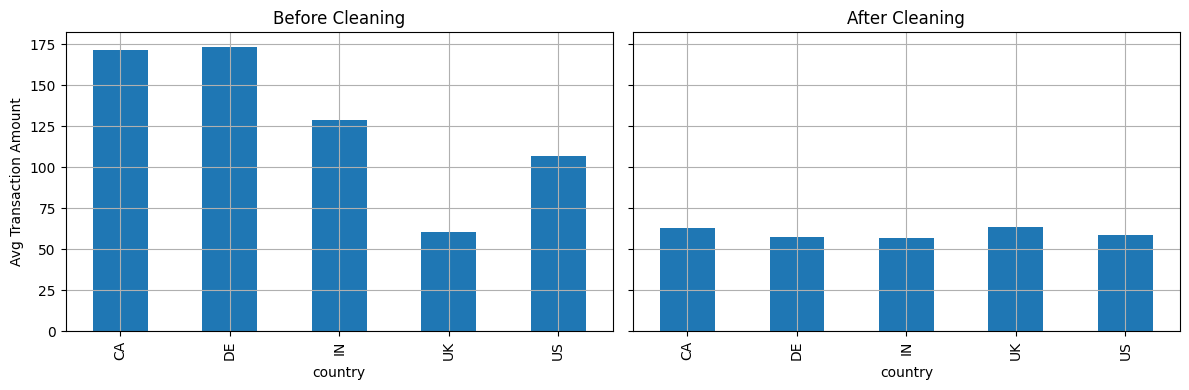

In [11]:
# Simple business metric: avg transaction amount by country

avg_before = df.groupby("country")["transaction_amount"].mean()
avg_after = clean_df.groupby("country")["transaction_amount"].mean()

print("Average transaction amount by country (BEFORE cleaning):")
display(avg_before)

print("\nAverage transaction amount by country (AFTER cleaning):")
display(avg_after)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

avg_before.plot(kind="bar", ax=axes[0], title="Before Cleaning")
axes[0].set_ylabel("Avg Transaction Amount")

avg_after.plot(kind="bar", ax=axes[1], title="After Cleaning")

plt.tight_layout()
plt.show()


## Step 4: From Hardcoded Rules → Config-Driven Pipeline

Instead of manually writing code for each check, we can define our rules in a **configuration dictionary**.

This makes it easier to:
- Reuse for multiple datasets
- Store rules in JSON/YAML
- Modify rules without changing code


In [ ]:

VALID_COUNTRIES = [
    "United Kingdom",
    "Germany",
    "France",
    "Netherlands",
    "Spain",
    "Portugal",
    "Italy",
    "Belgium",
    "Sweden",
    "Norway",
    "Finland",
    "Denmark",
    # add/adjust based on your dataset
]


In [ ]:
VALID_COUNTRIES = ["US", "UK", "IN", "DE", "CA"]
VALID_CATEGORIES = ["Electronics", "Clothing", "Grocery", "Beauty"]

QUALITY_CONFIG = {
    "age": {
        "min": 18,
        "max": 100
    },
    "transaction_amount": {
        "min": 0.01,
        "max": 1000
    },
    "customer_id": {
        "not_null": True
    },
    "country": {
        "allowed_values": VALID_COUNTRIES
    },
    "product_category": {
        "allowed_values": VALID_CATEGORIES
    }
}


**Generic Check Engine**

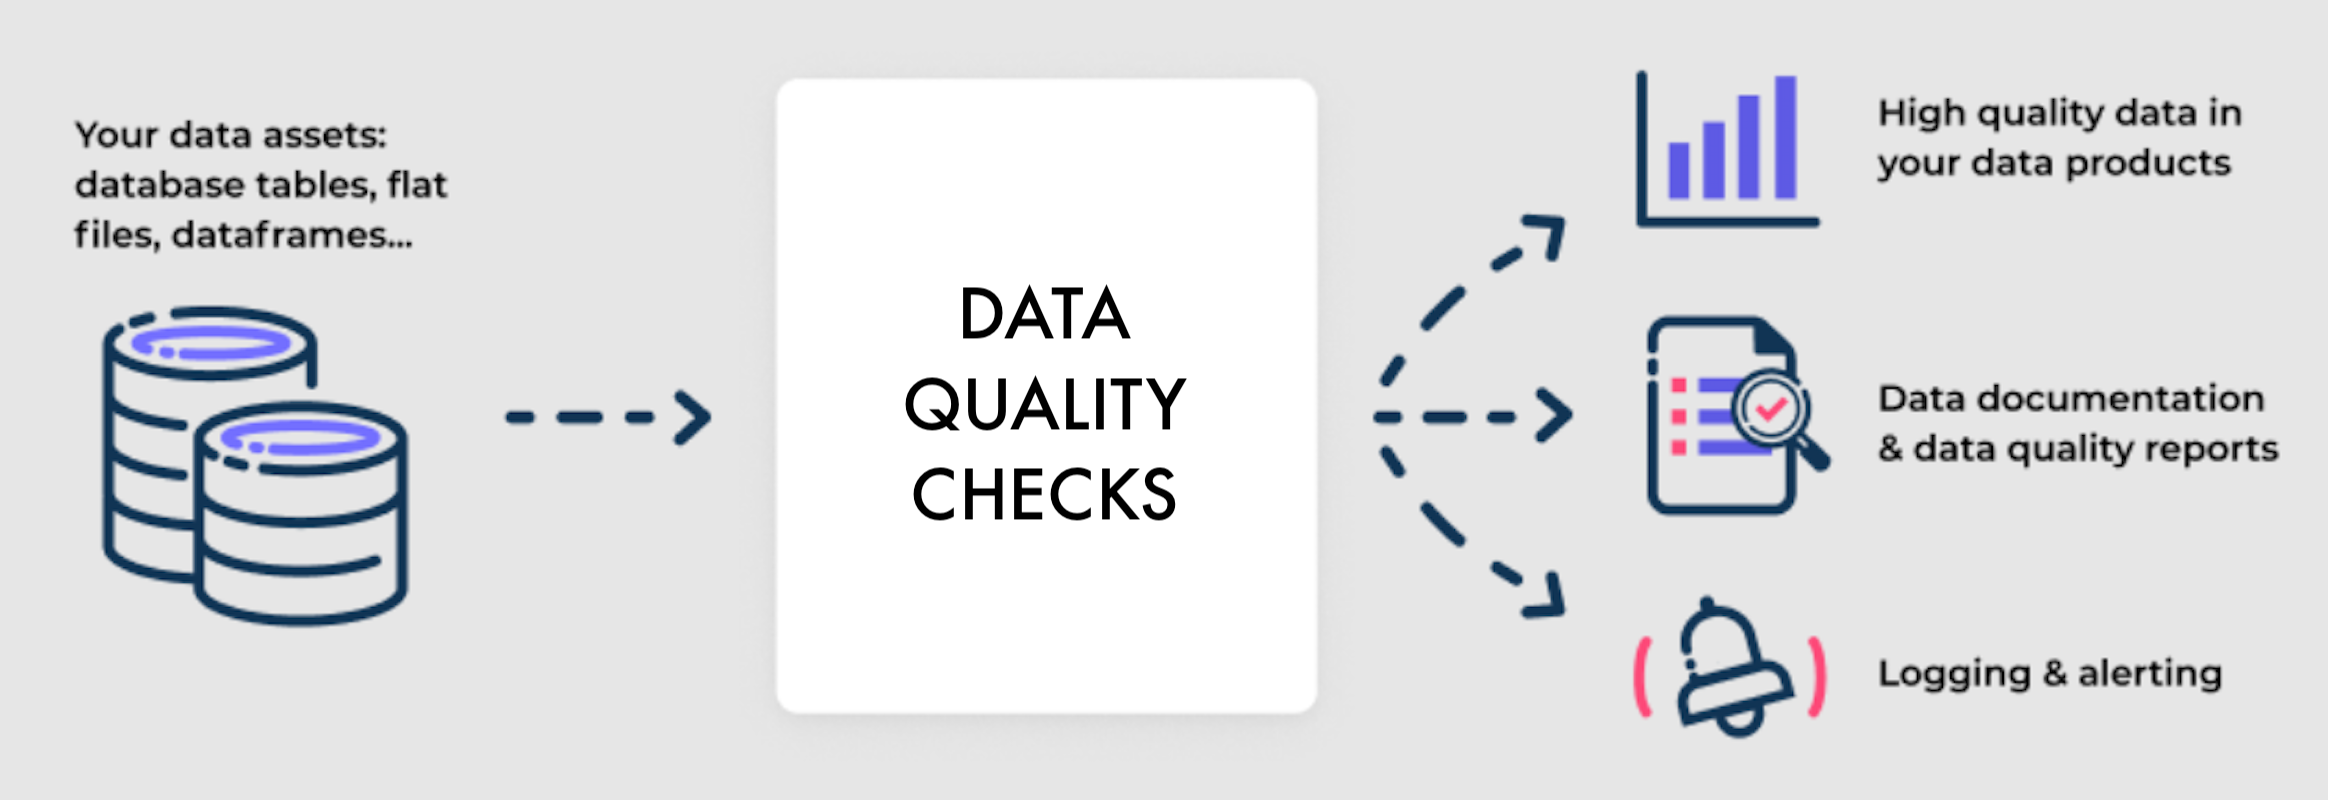

In [ ]:
df.columns


Index(['customer_id', 'age', 'country', 'product_category',
       'transaction_amount'],
      dtype='object')

In [ ]:
def validate_column(df, col, rules):
    s = df[col]
    checks = {}

    if "min" in rules:
        checks["min"] = s >= rules["min"]
    if "max" in rules:
        checks["max"] = s <= rules["max"]
    if rules.get("not_null"):
        checks["not_null"] = s.notna()
    if "allowed_values" in rules:
        checks["allowed_values"] = s.isin(rules["allowed_values"])
    if "range" in rules:
        start, end = rules["range"]
        s_dates = pd.to_datetime(s, errors="coerce")
        checks["range"] = s_dates.between(start, end, inclusive="both")

    # Combine into a single Series (all checks for this column)
    if checks:
        col_result = pd.DataFrame(checks).all(axis=1)
    else:
        col_result = pd.Series(True, index=df.index)

    return col_result, checks  # second output is detailed per-rule if needed


def run_config_checks(df, config):
    results = pd.DataFrame(index=df.index)
    detail = {}

    for col, rules in config.items():
        col_valid, col_detail = validate_column(df, col, rules)
        results[f"{col}_valid"] = col_valid
        detail[col] = col_detail

    results["row_valid"] = results.all(axis=1)
    return results, detail

config_results, config_detail = run_config_checks(df, QUALITY_CONFIG)
config_results.head()


age_valid  transaction_amount_valid  customer_id_valid  country_valid  \
0      False                      True               True           True   
1       True                      True               True           True   
2       True                      True               True           True   
3       True                      True               True           True   
4       True                      True               True           True   

   product_category_valid  row_valid  
0                    True      False  
1                    True       True  
2                    True       True  
3                    True       True  
4                    True       True

**3.3 Compare Basic vs Config Pipeline (Quick Sanity Check)**

In [ ]:
df_with_checks = df.copy()
df_with_checks["check_row_valid"] = config_results["row_valid"]

(df_with_checks["check_row_valid"] == config_results["row_valid"]).value_counts()


True    510
Name: count, dtype: int64

### Mini Exercise 3

1. Add a `max` rule for `quantity` (e.g., maximum 100 units per order).  
2. Add a new column `discount_rate` between 0 and 1, then:
   - Inject some invalid values (e.g., -0.5, 1.5)
   - Add rules for it in `QUALITY_CONFIG`
3. Re-run `run_config_checks` and compute how many rows are invalid because of `discount_rate`.


## Step 5: From Row Flags → Data Quality Metrics

We'll transform our boolean validation results into metrics like:

- `% valid quantity`
- `% valid unit_price`
- `% rows fully valid`
- `% missing per column`

These can be tracked over time or per batch.


In [ ]:
def compute_quality_metrics(df, validation_results):
    metrics = {}

    # per-column validity
    for col in validation_results.columns:
        metrics[f"{col}_valid_pct"] = validation_results[col].mean() * 100

    # missingness per raw column
    for col in df.columns:
        metrics[f"{col}_missing_pct"] = df[col].isna().mean() * 100

    return pd.Series(metrics)

quality_metrics = compute_quality_metrics(df, config_results)
quality_metrics


age_valid_valid_pct                    94.117647
transaction_amount_valid_valid_pct     97.450980
customer_id_valid_valid_pct           100.000000
country_valid_valid_pct                97.058824
product_category_valid_valid_pct       98.039216
                                         ...    
customer_id_missing_pct                 0.000000
age_missing_pct                         3.921569
country_missing_pct                     2.941176
product_category_missing_pct            0.000000
transaction_amount_missing_pct          0.000000
Length: 11, dtype: float64

5.2 Batch-Level Summary

In [ ]:
def summarize_quality(df, validation_results, batch_name="batch_1"):
    metrics = compute_quality_metrics(df, validation_results)
    metrics["batch_name"] = batch_name
    metrics["num_rows"] = len(df)
    return metrics

batch_summary = summarize_quality(df, config_results, batch_name="2024-11-01_ingest")
batch_summary


age_valid_valid_pct                           94.117647
transaction_amount_valid_valid_pct             97.45098
customer_id_valid_valid_pct                       100.0
country_valid_valid_pct                       97.058824
product_category_valid_valid_pct              98.039216
                                            ...        
country_missing_pct                            2.941176
product_category_missing_pct                        0.0
transaction_amount_missing_pct                      0.0
batch_name                            2024-11-01_ingest
num_rows                                            510
Length: 13, dtype: object

### Mini Exercise 4

1. Imagine you run this pipeline **daily**. Which 3 metrics would you put on a dashboard?  
2. Write 1–2 sentences about **thresholds** (e.g., "if `row_valid_pct` < 95%, trigger an alert").
3. (Optional) Create a simple bar plot of a few metrics using `matplotlib` or `seaborn`.


## **Simple Anomaly Detection for “Weird but Valid” Data (Advanced Taste)**

Even if data passes validation rules, it can still be weird (e.g., very high order values).
We’ll create a simple transaction_amount field and use a z-score approach to flag anomalies.

Z-Score Based Anomaly Flag

In [12]:
def flag_amount_outliers(df, col="transaction_amount", z_thresh=3.0):
    # only on non-null, valid rows
    vals = df[col].astype(float)
    mean = vals.mean()
    std = vals.std()

    z_scores = (vals - mean) / std
    return np.abs(z_scores) > z_thresh

df["amount_anomaly"] = flag_amount_outliers(df)
df["amount_anomaly"].value_counts()


amount_anomaly
False    505
True       5
Name: count, dtype: int64

6.2 Combine Validation + Anomaly Flags

In [20]:
# 1) Rebuild row_valid directly from the current df + rules
allowed_countries = ["US", "UK", "IN", "DE", "CA"]
allowed_categories = ["Electronics", "Clothing", "Grocery", "Beauty"]

df["row_valid"] = (
    df["age"].between(18, 100) &
    df["transaction_amount"].between(0, 1000) &
    df["country"].isin(allowed_countries) &
    df["product_category"].isin(allowed_categories)
)

# 2) Define an amount anomaly flag (top 1% as "suspicious")
threshold = df["transaction_amount"].quantile(0.99)
df["amount_anomaly"] = df["transaction_amount"] > threshold

# 3) Assign quality labels
df["quality_label"] = np.select(
    [
        ~df["row_valid"],                       # any validation failed
        df["row_valid"] & df["amount_anomaly"]  # valid but anomalous amount
    ],
    [
        "INVALID",
        "SUSPICIOUS"
    ],
    default="OK"
)

df["quality_label"].value_counts()


quality_label
OK            443
INVALID        66
SUSPICIOUS      1
Name: count, dtype: int64

Now that things are clear, let's put your mind to a test.

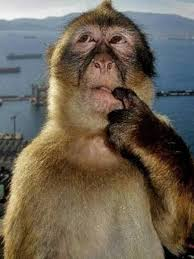

## Reflection & Progressive Exercises

### Reflection

1. Look at the **data quality report before cleaning** (`dq_before`) and **after cleaning** (`dq_after`):
   - Which column had the most problems originally?
   - Did any column still look suspicious even after cleaning?
2. Look at the **average transaction amount by country** before vs after:
   - Did any country’s average change a lot?
   - What wrong conclusion could a manager make if they only saw the “before” chart?



## Exercise 1 – Read What the Data Is Telling You (Easy!!)

**Goal:** Practice *interpreting* the data-quality report.

1. For each column in `dq_before`:
   - Write down the `missing_pct` and `invalid_pct`.
2. Do the same for `dq_after`.
3. In your own words, answer:
   - “Which column was dirtiest before cleaning?”
   - “Which column improved the most after cleaning?”

*Deliverable:* 3–5 bullet points summarizing what you learned about the raw vs clean data.



## Exercise 2 – Change One Rule, Watch the Ripple (Medium!)

**Goal:** See how changing rules changes what counts as “garbage”.

1. Change the age rule in `validation_rules` from:

   ```python
   "age": {"min": 18, "max": 100}

to:

  ```python
  "age": {"min": 21, "max": 90}
  ```

Re-run:

- dq_before = data_quality_report(df, validation_rules)

- The cleaning pipeline

- The before vs after country-average code

Answer:

- Did invalid_pct for age go up or down?

- Did any country’s average transaction amount change noticeably?

### Exercise 3  – Add a New Field to the GIGO Pipeline (Hard!!!!!)

Extend your GIGO pipeline to handle a new column called `loyalty_score`.

**Question:**

You now receive a new field `loyalty_score` that is supposed to be a value between 0 and 1 for each customer.

1. How would you:
   - Add `loyalty_score` into your existing data-quality contract (validation rules)?
   - Update your data-quality report so it also checks missing and invalid values for `loyalty_score`?
   - Modify your cleaning pipeline so invalid `loyalty_score` values are fixed or imputed?

2. Finally, explain in 3–4 sentences:
   - How could uncleaned or invalid `loyalty_score` values affect any downstream model
     (for example, churn prediction or customer segmentation)?


##**References**

- Endel, F., et al. (2015). Data Wrangling: Making data useful again. *IFAC-PapersOnLine, 48*(1), 111–116.  
(Discusses practical issues in data wrangling and references Kandel et al. 2011.)  
https://www.sciencedirect.com/science/article/pii/S2405896315001986  

- Pandas Development Team. (n.d.). *pandas Documentation*.  
Official docs for DataFrame operations, missing data handling, and groupby/aggregation.  
https://pandas.pydata.org/docs/  

- DataCamp. (2024). *Great Expectations Tutorial: Validating Data with Python*.  
Hands-on tutorial showing how to build validation suites around tabular data.  
https://www.datacamp.com/tutorial/great-expectations-tutorial  

- Batini, C., & Scannapieco, M. (2016). *Data and Information Quality: Dimensions, Principles and Techniques*. Springer.  


- OpenAI. (2025). *ChatGPT (GPT-5.1 Thinking)* [Large language model]. Assistance used for drafting code examples, pedagogical structure, and explanatory text in this notebook. Retrieved from https://chat.openai.com/
 - WhiteRaven_M. (2023, February 23). *What are the general "checklist" of data cleaning and pre-processing before doing any analysis or modeling?* [Online forum post]. r/datascience, Reddit. https://www.reddit.com/r/datascience/comments/1bdc8iy/what_are_the_general_checklist_of_data_cleaning/





# **License**

Copyright (c) 2025 Amantha Bhaskarabhatla

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.